# PAN - Atribuição Autoral - 2018 - Modelo Char



In [1]:
%matplotlib inline

In [2]:
#python basic libs
import os;
from os.path import join as pathjoin;
import zipfile;

import re;
import random;
import json;
from collections import defaultdict;
from pprint import pprint
from time import time

In [3]:
#data analysis libs
import numpy as np;
import pandas as pd;
from pandas.plotting import scatter_matrix;
import matplotlib.pyplot as plt;


import seaborn as sns;

In [4]:
#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import feature_selection;

#preprocessing and transformation
from sklearn import preprocessing;
from sklearn.preprocessing import MaxAbsScaler;
from sklearn.decomposition import PCA;

from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression


#
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score;

NLP Libs

In [5]:
# import spacy;
# import nltk;
# import gensim
# import logging
# from gensim.models import KeyedVectors
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.CRITICAL)

In [6]:
from IPython.display import Markdown, display, HTML

libraries configurations

In [7]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
np.set_printoptions(precision=4)
pd.options.display.float_format = '{:,.4f}'.format
sns.set(color_codes=True);

In [9]:
import platform;
import sklearn;
import scipy;

Markdown(
    "|%-15s|%-65s|\n"%("PACK","VERSION") +
    "|%-15s|%-65s|\n"%('-'*15,'-'*65) +
    ('\n'.join(
    "|%-15s|%-45s| " % (pack, version.strip())
    for pack, version in
    zip(['SO','NumPy','SciPy','Scikit-Learn','Seaborn'],
        [platform.platform(), np.__version__, scipy.__version__,
         sklearn.__version__, sns.__version__])

)))

|PACK           |VERSION                                                          |
|---------------|-----------------------------------------------------------------|
|SO             |Darwin-18.2.0-x86_64-i386-64bit              | 
|NumPy          |1.15.4                                       | 
|SciPy          |1.1.0                                        | 
|Scikit-Learn   |0.20.1                                       | 
|Seaborn        |0.9.0                                        | 

In [10]:
import seaborn as sns;
sns.set(color_codes=True);

In [11]:
import platform; print(platform.platform())
print("NumPy", np.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
print("seaborn", sns.__version__)

Darwin-18.2.0-x86_64-i386-64bit
NumPy 1.15.4
SciPy 1.1.0
Scikit-Learn 0.20.1
seaborn 0.9.0


In [12]:
np.set_printoptions(precision=4)
pd.options.display.float_format = '{:,.4f}'.format

In [13]:
from skleanExtensions import DenseTransformer

### paths configuration

In [14]:
baseDir = '/Users/joseeleandrocustodio/dataScienceNotebook/PANAA2018';

corpusTraining    = 'pan18-cross-domain-authorship-attribution-training-dataset-2017-12-02';
corpusEvaluation = 'pan18-cross-domain-authorship-attribution-test-dataset2-2018-04-20';
corpusEach1 = 'AvaliacaoPT';

currentCorpus = corpusTraining;

inputDir= pathjoin(baseDir,currentCorpus);
outputDir= pathjoin(baseDir,'out');
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [15]:
import pan

In [16]:
problems = pan.readCollectionsOfProblemsFromZip(inputDir + '.zip');

In [17]:
problems[0]['problem']

'problem00001'

In [18]:
pd.DataFrame(problems)[['problem','language','authorCount','candidates','unknown']]

,problem,language,authorCount,candidates,unknown
0,problem00001,en,20,"[[graceful ones.\n\n""One more,"" Marvelous said...","[[a word it said, not wanting to see them anym..."
1,problem00002,en,5,"[[a mission.""\n\nJensen just raises an eyebrow...","[[don't mean you, technically, but it's just t..."
2,problem00003,fr,20,[[qui l'avait tué mais tout était de la faute ...,[[scène qui se déroulait entre leurs bras. Le ...
3,problem00004,fr,5,[[. Le canapé est vide et lorsqu'il passe deva...,"[[lui. Le silence m'insupporte et rapidement, ..."
4,problem00005,it,20,"[[Eppure lui la mappa l’aveva stampata, dannaz...",[[nella sua prima casa da solo.\nAveva usato a...
5,problem00006,it,5,[[Yato ha trovato una lettera sul suo comodino...,"[[Bah, dà qua, che peggio di così non può anda..."
6,problem00007,pl,20,[[zmienił zdanie. Niech się stworzonko pobawi....,"[[Przynajmniej tak sądził chłopak, dopóki nie ..."
7,problem00008,pl,5,"[[Słowem, które Sherlock najczęściej słyszał w...",[[zamknął oczy. Serce waliło mu jak oszalałe; ...
8,problem00009,sp,20,[[pero no lo ama como ama a Guignol –explicó e...,"[[de tanto contacto entre ellos, fue que Albus..."
9,problem00010,sp,5,"[[incapaz de señalar un momento exacto, un pun...","[[editores son magos, así que tiene el peor hu..."


In [19]:
def outputAnswer(test_pred,test_filename,answerFile):
    # Writing output file using the same format as PAN 
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)

### examinando o parametro min_df isoladamente

In [106]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ')
    
    train_docs, train_labels, _  = zip(*problem['candidates'])
    test_docs, test_labels, test_filename   = zip(*problem['unknown'])
    
    pipeline = Pipeline([
        ('vect',   TfidfVectorizer(analyzer='char',
                                   min_df=0.05,
                                   max_df=1.0,
                                   norm='l1',
                                   ngram_range=(3,5),
                                   sublinear_tf=True,
                                   smooth_idf=True,
                                   lowercase =False)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__min_df':(2,0.01,0.05,0.1)
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=3,
                               iid=False,
                               verbose=False,
                               scoring='f1_macro'
                              )
    
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("GridSearch: %0.3fs" % (time() - t0), end=' ')
    print("Best score: %0.3f" % grid_search.best_score_, end=' ')
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    f1 = f1_score(test_labels,test_pred, average='macro')
    precision = precision_score(test_labels,test_pred, average='macro')
    recall =  recall_score(test_labels,test_pred, average='macro')
    accuracy =   accuracy_score(test_labels,test_pred)
    
    return {
                'problem'  :       problem['problem'],
                "language"      :       problem['language'],
                'AuthorCount'   :       len(set(train_labels)),
                "train_doc_size":       len(train_docs),
                "train_caract_per_doc": sum([len(l) for l in train_docs])/len(train_docs),
                "test_doc_size" :       len(test_docs),
                "test_caract_per_doc":  sum([len(l) for l in test_docs])/len(test_docs),
                
                'f1'       : round(f1,3),
                'precision': round(precision,3),
                'recall'   : round(recall,3),
                'accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_, best_parameters;

In [107]:
result = [];
cv_result = [];
best_parameters = [];
for problem in problems:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore");
        r, c, b = runML(problem);
        result.append(r);
        cv_result.append(c);
        b['problem'] = problem['problem'];
        best_parameters.append(b);


Problem: problem00001,  language: en,  GridSearch: 18.430s Best score: 0.742 Best parameters set:
	vect__min_df: 0.01

Problem: problem00002,  language: en,  GridSearch: 5.028s Best score: 0.907 Best parameters set:
	vect__min_df: 0.01

Problem: problem00003,  language: fr,  GridSearch: 19.495s Best score: 0.743 Best parameters set:
	vect__min_df: 0.01

Problem: problem00004,  language: fr,  GridSearch: 4.798s Best score: 0.753 Best parameters set:
	vect__min_df: 2

Problem: problem00005,  language: it,  GridSearch: 20.032s Best score: 0.524 Best parameters set:
	vect__min_df: 0.01

Problem: problem00006,  language: it,  GridSearch: 5.065s Best score: 0.876 Best parameters set:
	vect__min_df: 2

Problem: problem00007,  language: pl,  GridSearch: 24.666s Best score: 0.746 Best parameters set:
	vect__min_df: 2

Problem: problem00008,  language: pl,  GridSearch: 6.025s Best score: 0.633 Best parameters set:
	vect__min_df: 2

Problem: problem00009,  language: sp,  GridSearch: 19.582s Best

In [22]:
for c,p in zip(cv_result, problems):
    c['problem'] = p['problem']
df =  pd.concat([
    pd.DataFrame(c) for c in cv_result
])
df = df[df.rank_test_score == 1]

df = df[['problem', 'mean_test_score','std_test_score','param_vect__min_df']]
df.sort_values(['problem','mean_test_score','param_vect__min_df'])

,problem,mean_test_score,std_test_score,param_vect__min_df
1,problem00001,0.6711,0.1173,0.0100
1,problem00002,0.8178,0.1290,0.0100
2,problem00002,0.8178,0.1290,0.0500
3,problem00002,0.8178,0.1290,0.1000
0,problem00002,0.8178,0.1290,2
0,problem00003,0.6678,0.0937,2
1,problem00004,0.7533,0.1938,0.0100
2,problem00004,0.7533,0.1938,0.0500
2,problem00005,0.5334,0.0413,0.0500
1,problem00006,0.8222,0.1257,0.0100


### analisando os demais parametros

In [25]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ')
    
    train_docs, train_labels, _ = zip(*problem['candidates'])
    test_docs, test_labels, test_filename = zip(*problem['unknown'])
    
    pipeline = Pipeline([
        ('vect',   TfidfVectorizer(analyzer='char',
                                   min_df=0.01,
                                   max_df=1.0,
                                   norm='l1',
                                   lowercase =False)),
        ('scaler', MaxAbsScaler()),
        ('dense',  DenseTransformer()),
        ('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__ngram_range' :((2,3),(2,4),(2,5)),
        'vect__use_idf'     :(True, False),
        'vect__sublinear_tf':(True, False),
        'vect__norm':('l1','l2'),
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=3,
                               iid=False,
                               n_jobs=-1,
                               verbose=False,
                               scoring='f1_macro')
    
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("Gridsearh %0.3fs" % (time() - t0), end=' ')

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    print("'"+problem['language']+"':{")
    for param_name in sorted(parameters.keys()):
        print("\t'%s': %r," % (param_name, best_parameters[param_name]))
    print("},")
    
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    #evaluation train
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    outputAnswer(test_pred,test_filename,answerFile)
    
    #calculating the performance using PAN evaluation code
    grountTruthFile = pathjoin(inputDir, problem['problem'], 'ground-truth.json');
    f1,precision,recall,accuracy=pan.evaluate(grountTruthFile,answerFile);
    
    return {
                'problem'  :       problem['problem'],
                "language"      :       problem['language'],
                'authorCount'   :       len(set(train_labels)),
                "train_doc_size":       len(train_docs),
                "test_doc_size" :       len(test_docs),
                
                'f1'       : round(f1,3),
                'precision': round(precision,3),
                'recall'   : round(recall,3),
                'accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_,best_parameters, grid_search.best_estimator_;

In [26]:
result = [];
cv_result = [];
best_parameters = [];
estimators = [];
for problem in problems:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore");
        r, c, b, e = runML(problem);
        result.append(r);
        cv_result.append(c);
        estimators.append(e);
        b['problem'] = problem['problem'];
        best_parameters.append(b);


Problem: problem00001,  language: en,  Gridsearh 57.416s Best score: 0.742
Best parameters set:
'en':{
	'vect__ngram_range': (2, 5),
	'vect__norm': 'l1',
	'vect__sublinear_tf': True,
	'vect__use_idf': True,
},

Problem: problem00002,  language: en,  Gridsearh 11.254s Best score: 0.907
Best parameters set:
'en':{
	'vect__ngram_range': (2, 5),
	'vect__norm': 'l1',
	'vect__sublinear_tf': True,
	'vect__use_idf': True,
},

Problem: problem00003,  language: fr,  Gridsearh 51.580s Best score: 0.754
Best parameters set:
'fr':{
	'vect__ngram_range': (2, 5),
	'vect__norm': 'l1',
	'vect__sublinear_tf': False,
	'vect__use_idf': True,
},

Problem: problem00004,  language: fr,  Gridsearh 10.904s Best score: 0.787
Best parameters set:
'fr':{
	'vect__ngram_range': (2, 4),
	'vect__norm': 'l2',
	'vect__sublinear_tf': True,
	'vect__use_idf': False,
},

Problem: problem00005,  language: it,  Gridsearh 49.729s Best score: 0.552
Best parameters set:
'it':{
	'vect__ngram_range': (2, 4),
	'vect__norm': 'l1',

In [27]:
df=pd.DataFrame(result)[['problem',
                     "language",
                     'authorCount',
                     "train_doc_size",
                     "test_doc_size", 
                     'f1','precision','recall' ,'accuracy']]

In [28]:
df

,problem,language,authorCount,train_doc_size,test_doc_size,f1,precision,recall,accuracy
0,problem00001,en,20,80,105,0.4630,0.4400,0.6030,0.5810
1,problem00002,en,5,20,21,0.5950,0.5580,0.7170,0.7140
2,problem00003,fr,20,80,49,0.6520,0.6620,0.7150,0.6730
3,problem00004,fr,5,20,21,0.6790,0.7750,0.8200,0.5710
4,problem00005,it,20,80,80,0.4480,0.4740,0.5450,0.5380
5,problem00006,it,5,20,46,0.5480,0.5540,0.6620,0.7610
6,problem00007,pl,20,80,103,0.3600,0.4150,0.4240,0.5240
7,problem00008,pl,5,20,15,0.6760,0.6500,0.8110,0.6670
8,problem00009,sp,20,80,117,0.6010,0.5710,0.7410,0.6840
9,problem00010,sp,5,20,64,0.7530,0.7860,0.7960,0.7810


In [30]:
df[['f1']].mean()

f1   0.5775
dtype: float64

In [31]:
languages={
    'en':'inglesa',
    'sp':'espanhola',
    'it':'italiana',
    'pl':'polonesa',
    'fr':'francesa'
}

In [69]:
for c,p in zip(cv_result, problems):
    c['problem'] = p['problem']
    c['authorCount'] = p ['authorCount']
    c['language'] = p ['language']
dfCV =  pd.concat([
    pd.DataFrame(c) for c in cv_result
])

params = {
    'param_vect__ngram_range':'ngram_range',
    'param_vect__sublinear_tf':'sublinear_tf',
    'param_vect__use_idf':'use_idf',
    'param_vect__norm':'norm'}
dfCV = dfCV[['problem','language', 'authorCount','rank_test_score', 'mean_test_score','std_test_score'] + list(params.keys())].rename(columns=params)
dfCV.sort_values(['problem','mean_test_score'],ascending=[True,False], inplace=True)
dfCV[dfCV.rank_test_score == 1]

,problem,language,authorCount,rank_test_score,mean_test_score,std_test_score,ngram_range,sublinear_tf,use_idf,norm
16,problem00001,en,20,1,0.7422,0.1593,"(2, 5)",True,True,l1
17,problem00001,en,20,1,0.7422,0.1593,"(2, 5)",True,False,l1
16,problem00002,en,5,1,0.9067,0.1320,"(2, 5)",True,True,l1
17,problem00002,en,5,1,0.9067,0.1320,"(2, 5)",True,False,l1
20,problem00002,en,5,1,0.9067,0.1320,"(2, 5)",True,True,l2
18,problem00003,fr,20,1,0.7544,0.1832,"(2, 5)",False,True,l1
13,problem00004,fr,5,1,0.7867,0.1570,"(2, 4)",True,False,l2
20,problem00004,fr,5,1,0.7867,0.1570,"(2, 5)",True,True,l2
10,problem00005,it,20,1,0.5524,0.0370,"(2, 4)",False,True,l1
8,problem00006,it,5,1,0.9111,0.1257,"(2, 4)",True,True,l1


## Saving the model

In [70]:
dfCV.to_csv('PANAA2018_CHAR.csv', index=False)

In [71]:
dfCV = pd.read_csv('PANAA2018_CHAR.csv', na_values='')

In [72]:
import pickle;
with open("PAN_AA_2018_CHAR.pkl","wb") as f:
    pickle.dump(estimators,f)

## understanding the model with reports

Podemos ver que para um mesmo problema mais de uma configuração é possível

In [73]:
dfCV.pivot_table(
            index=['problem','language'],
            columns=['ngram_range','sublinear_tf','norm'],
            values='mean_test_score'
        ).style.background_gradient(axis=1, cmap=plt.cm.Blues)

In [74]:
pd.options.display.precision = 3  
print(u"\\begin{table}[h]\n\\centering\n\\caption{Medida F1 para os parâmetros }")

print(re.sub(r'[ ]{2,}',' ',dfCV.pivot_table(
            index=['problem','language'],
            columns=['ngram_range','sublinear_tf','norm'],
            values='mean_test_score'
        ).to_latex()))
print ("\label{tab:modelocaracter}")
print(r"\end{table}")

\begin{table}[h]
\centering
\caption{Medida F1 para os parâmetros }
\begin{tabular}{llrrrrrrrrrrrr}
\toprule
 & ngram\_range & \multicolumn{4}{l}{(2, 3)} & \multicolumn{4}{l}{(2, 4)} & \multicolumn{4}{l}{(2, 5)} \\
 & sublinear\_tf & \multicolumn{2}{l}{False} & \multicolumn{2}{l}{True} & \multicolumn{2}{l}{False} & \multicolumn{2}{l}{True} & \multicolumn{2}{l}{False} & \multicolumn{2}{l}{True} \\
 & norm & l1 & l2 & l1 & l2 & l1 & l2 & l1 & l2 & l1 & l2 & l1 & l2 \\
problem & language & & & & & & & & & & & & \\
\midrule
problem00001 & en & 0.5722 & 0.6011 & 0.6139 & 0.6192 & 0.6716 & 0.7030 & 0.7120 & 0.7053 & 0.7023 & 0.6673 & 0.7422 & 0.7287 \\
problem00002 & en & 0.6933 & 0.6489 & 0.6933 & 0.6789 & 0.6933 & 0.6044 & 0.8178 & 0.8178 & 0.8178 & 0.7289 & 0.9067 & 0.8622 \\
problem00003 & fr & 0.6059 & 0.5879 & 0.6303 & 0.6503 & 0.6676 & 0.6795 & 0.6894 & 0.7058 & 0.7347 & 0.6898 & 0.7125 & 0.7425 \\
problem00004 & fr & 0.6852 & 0.6333 & 0.6444 & 0.6413 & 0.6714 & 0.6644 & 0.7159 & 0.74

In [75]:
dfCV.ngram_range[0]

'(2, 5)'

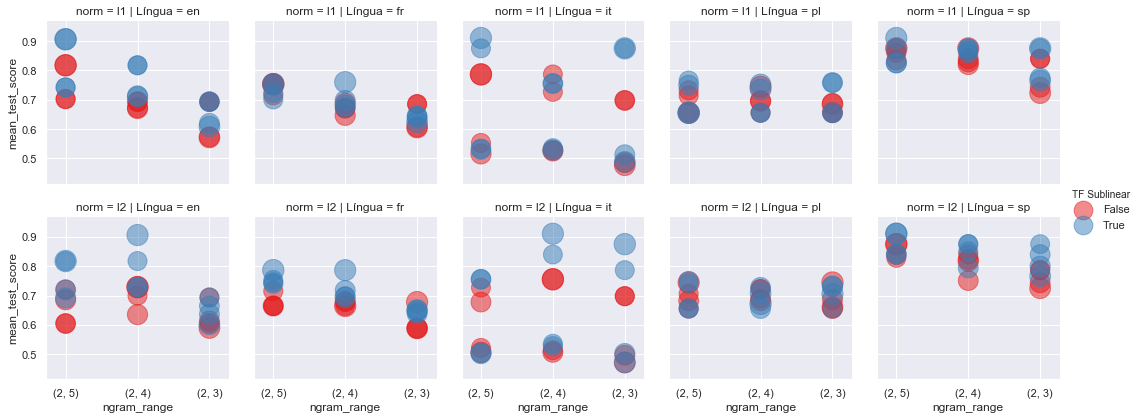

In [78]:
d = dfCV.copy()
d = d.rename(columns={'language':u'Língua', 'sublinear_tf':'TF Sublinear'})
d = d [ d.norm.isna() == False]
d.problem = d.apply(lambda x: x[u'Língua'] +" "+ str(x[u'problem']), axis=1)
#d.ngram_range = d.apply(lambda x: str(x[u'ngram_range'][0]) +" "+ str(x[u'ngram_range'][1]), axis=1)

d.std_test_score =d.std_test_score / d.std_test_score.quantile(0.95) *500;
d.std_test_score +=1;
d.std_test_score = d.std_test_score.astype(np.int64)
g = sns.FacetGrid(d, col='Língua', hue='TF Sublinear',  row="norm", height=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score",alpha=0.5, s=d.std_test_score.values).add_legend();
#sns.pairplot(d, hue="TF Sublinear", vars=["autorNumber", "mean_test_score"])


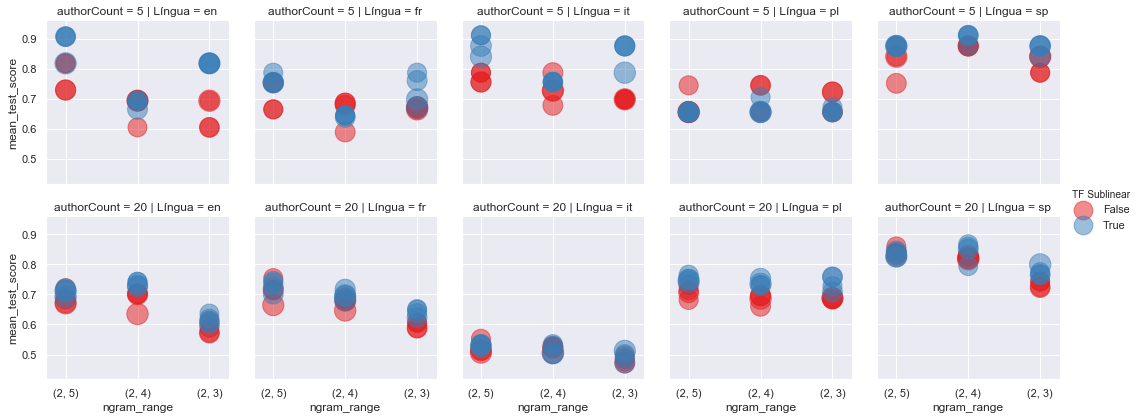

In [77]:
g = sns.FacetGrid(d, row='authorCount', hue='TF Sublinear',  col=u"Língua", height=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score", alpha=0.5, s=d.std_test_score.values).add_legend();

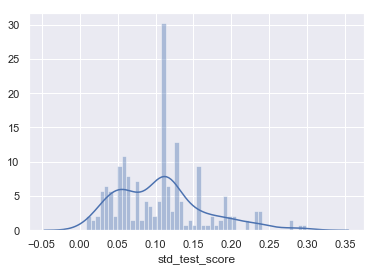

In [79]:
sns.distplot(dfCV.std_test_score, bins=50);

In [80]:
import statsmodels.api as sm

In [89]:
d = dfCV[['mean_test_score','problem', 'language','sublinear_tf','norm','ngram_range']].copy();
d.sublinear_tf=d.sublinear_tf.apply(lambda x: 1 if x else 0)
d.norm=d.norm.apply(lambda x: 1 if x == 'l1' else 0)

d.norm.fillna(value='None', inplace=True);

_, d['ngram_max'] = zip(*d.ngram_range.str.replace(r'[^\d,]','').str.split(',').values.tolist())
#d.ngram_min = d.ngram_min.astype(np.uint8);
d.ngram_max = d.ngram_max.astype(np.uint8);
d.drop(columns=['ngram_range','problem'], inplace=True)
#d['intercept'] = 1;

d=pd.get_dummies(d, columns=['language'])

In [90]:
d.describe()

,mean_test_score,sublinear_tf,norm,ngram_max,language_en,language_fr,language_it,language_pl,language_sp
count,240.0000,240.0000,240.0000,240.0000,240.0000,240.0000,240.0000,240.0000,240.0000
mean,0.7141,0.5000,0.5000,4.0000,0.2000,0.2000,0.2000,0.2000,0.2000
std,0.1051,0.5010,0.5010,0.8182,0.4008,0.4008,0.4008,0.4008,0.4008
min,0.4709,0.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.6556,0.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.7092,0.5000,0.5000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.7867,1.0000,1.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,0.9111,1.0000,1.0000,5.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [91]:
mod = sm.OLS( d.iloc[:,0], d.iloc[:,1:])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        mean_test_score   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     27.29
Date:                Fri, 22 Feb 2019   Prob (F-statistic):           3.45e-27
Time:                        01:36:57   Log-Likelihood:                 272.83
No. Observations:                 240   AIC:                            -529.7
Df Residuals:                     232   BIC:                            -501.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
sublinear_tf     0.0380      0.010      3.729      0.000       0.018       0.058
norm             0.0118      0.010      1.153      0.250      -0.008       0.032
ngram_max        0.0281      0.006      4.506      0.000       0.016       0.040
language_en      0.5710      0.028     20.121      0.000       0.515       0.627
language_fr      0.5474      0.028     19.290      0.000       0.492       0.603
language_it      0.5090      0.028     17.937      0.000       0.453       0.565
language_pl      0.5590      0.028     19.698      0.000       0.503       0.615
language_sp      0.6968      0.028     24.553      0.000       0.641       0.753
==============================================================================
Omnibus:                       14.880   Durbin-Watson:                   0.331
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.035
Skew:                           0.444   Prob(JB):                     4.46e-05
Kurtosis:                       4.102   Cond. No.                         48.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

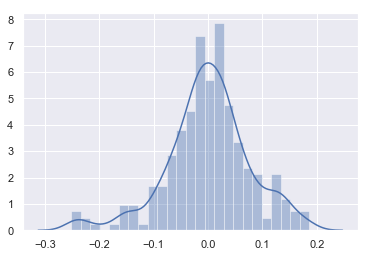

In [94]:
sns.distplot(res.predict()-d.iloc[:,0].values, bins=25);

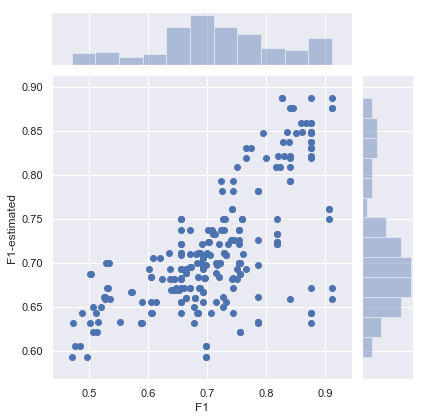

In [95]:
sns.jointplot(x='F1',y='F1-estimated',data=pd.DataFrame({'F1':d.iloc[:,0].values, 'F1-estimated':res.predict()}));